# Imaging Performance Comparison (Flare)
This notebook loops over different noise levels and calibration errors to generate, corrupt, image, and compare solar flare datasets.

In [ ]:
import fasr_solar_simul as fss
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j1
from scipy.constants import c
import os
from casatasks import tclean, applycal, clearcal
from datetime import datetime
from pathlib import Path
from tqdm import tqdm

# Speed of light in m/s
C_LIGHT = c
import matplotlib
%matplotlib inline

In [ ]:
from importlib import reload

reload(fss)
target = 'flare'

## Setup a Log Spiral Configuration

In [ ]:
# %matplotlib notebook
%matplotlib inline
from importlib import reload

reload(fss)
# Define log-spiral parameters
array_config = {"n_arms": 3, "antennas_per_arm": 56, "alpha": 1.0, "gamma": 0.55, "r0": 1.5, "r_max": 1800, "n_turn": 2,
                "latitude": 35}

# for gam in np.linspace(0.3, 1, 8):
# array_config = {"n_arms": 3, "antennas_per_arm": 56, "alpha": 1.0, "gamma": gam, "r0": 1.5, "r_max": 1800, "n_turn": 2,
#                 "latitude": 35}
positions_logspiral = fss.generate_log_spiral_antenna_positions(**array_config)
figname = (
    f"fig-fasr_Log_Spiral-{len(positions_logspiral)}-"
    f"n_arms={array_config['n_arms']}-antennas_per_arm={array_config['antennas_per_arm']}-"
    f"alpha={array_config['alpha']:.2f}-gamma={array_config['gamma']:.2f}-"
    f"r0={array_config['r0']:.1f}-r_max={array_config['r_max']:.0f}-n_turn={array_config['n_turn']:.1f}.jpg")
print(f'fig saved to {figname}')
figsubfolder = figname.rstrip('.jpg')
formatted_params = [
    rf"$n_{{\rm arms}}={array_config['n_arms']}$",
    rf"$\mbox{{antennas per arm}}={array_config['antennas_per_arm']}$",
    rf"$\alpha={array_config['alpha']:.2f}$",
    rf"$\gamma={array_config['gamma']:.2f}$",
    rf"$r_0={array_config['r0']:.1f}\,\mbox{{m}}$",
    rf"$r_{{\rm max}}={array_config['r_max']:.0f}\,\mbox{{m}}$",
    rf"$n_{{\rm turn}}={array_config['n_turn']:.1f}$"
]

# Create a full string that also includes the spiral equation.
array_config_str = (
    rf"$n_{{arms}}={array_config['n_arms']}, "
    rf"n_{{perarm}}={array_config['antennas_per_arm']}, "
    rf"\alpha={array_config['alpha']:.2f}, \gamma={array_config['gamma']:.2f}, "
    rf"r_0={array_config['r0']:.1f}\,m, r_{{max}}={array_config['r_max']:.0f}\,m, "
    rf"n_{{turn}}={array_config['n_turn']:.1f}$"
)
fss.plot_all_panels(positions_logspiral, "Log Spiral", frequency=2, figname=figname,
                    array_config_str=array_config_str)


## Save the cfg file

In [ ]:
config_file = f"fasr_Log_Spiral-{len(positions_logspiral)}.cfg"
os.system('rm -rf ' + config_file)
fss.write_casa_antenna_list(config_file, positions_logspiral)

# Imaging Performance Comparison
looping over different noise levels and calibration errors to generate, corrupt, image, and compare solar targetflare datasets

## set up the simulation

In [ ]:
from importlib import reload

reload(fss)

In [ ]:
# List of all available frequencies in GHz
freqlistALL = ['01.25GHz', '01.58GHz', '01.90GHz', '02.23GHz', '02.55GHz', '02.88GHz', '03.20GHz', '03.53GHz',
               '03.86GHz', '04.18GHz', '04.51GHz', '04.83GHz', '05.15GHz', '05.48GHz', '05.80GHz', '06.13GHz',
               '06.45GHz', '06.78GHz', '07.11GHz', '07.43GHz', '07.76GHz', '08.08GHz', '08.40GHz', '08.73GHz',
               '09.05GHz', '09.38GHz', '09.70GHz', '10.03GHz', '10.35GHz', '10.68GHz', '11.01GHz', '11.33GHz',
               '11.65GHz', '11.98GHz', '12.30GHz', '12.63GHz', '12.95GHz', '13.28GHz', '13.60GHz', '13.93GHz',
               '14.26GHz', '14.58GHz', '14.90GHz', '15.23GHz', '15.55GHz', '15.88GHz', '16.20GHz', '16.53GHz',
               '16.85GHz', '17.18GHz', '17.50GHz', '17.83GHz', ]

# List of configurations
project = 'FASR'
config_files = ['fasr_Log_Spiral-168.cfg', 'fasr-a-spiral-168-opt.cfg']

## Antenna temperature noise levels
noise_levels = ['5000K']

## Define the fractional gain errors tuples: (phase and amplitude)
## A phase error of x radians has the same effects as an amplitude error of 100 x %
## 5.7 deg (0.1 radians, or 1.6 % of 2pi) pha error is equivalent to 10 % of amp error.
# cal_errors = [(0.2, 0.2), (0.1, 0.1), (0.05, 0.05), (0.02, 0.02)]
cal_errors = [fss.equivalent_amp_pha_error(l, unit='deg') for l in [0, 2, 5, 10]]
print(cal_errors)

# Select every 16th frequency for processing
freq_list = freqlistALL[::16]

# Reference timestamp for the observation series
reftime_obj = fss.get_local_noon_utc(config_files[0], datetime(2017, 9, 10, 15, 45, 0))

# Flags to control overwriting existing data products
overwrite_ms = False  # Overwrite measurement set?
overwrite_im = False  # Overwrite image products?
overwrite_plot = True  # Overwrite existing plots?

# Deconvolution algorithm choice
deconvolver = 'hogbom'
# deconvolver = 'multiscale' ## this will be much slower than hogbom

# Imaging parameters (in seconds)
integration_time = 1  # Time per integration
duration = [1, 3]  # Total imaging duration
duration = [1]  # Total imaging duration

## predict obs and image

<img src="FASR/msfiles/flare/uv.png" alt="UV" width="600px"/>

In [ ]:
%matplotlib inline
reload(fss)

reftime = reftime_obj.strftime('%Y/%m/%d/%H:%M:%S')

figdir = os.path.join(project, figsubfolder, target)
if not os.path.exists(figdir):
    os.makedirs(figdir)

for dur in duration:
    for config_file in config_files:
        cfg_suffix = os.path.basename(config_file.rstrip(".cfg"))
        for freqstr in freq_list:
            solar_model = f'Eruptive_Flare/sep10_flare_cs_model.{freqstr}.I.fits'
            for noise in noise_levels:
                for erridx, (phaerr, amperr) in enumerate(cal_errors):
                    gaintable = [f'caltb_FASR_corrupt_{np.int_(phaerr * 100)}pct.amp',
                                 f'caltb_FASR_corrupt_{np.int_(amperr * 100)}pct.ph']
                    msname = fss.make_msname(project, target, freqstr, reftime_obj, dur, integration_time, config_file,
                                             noise)
                    imname = fss.make_imname(msname, deconvolver, phaerr, amperr)
                    msfile = f'{msname}.ms'
                    if os.path.exists(msfile):
                        if overwrite_ms:
                            os.system('rm -rf ' + msfile)
                        else:
                            pass

                    if not os.path.exists(msfile):
                        fss.generate_ms(config_file, solar_model, reftime, freqstr, integration_time=integration_time,
                                        duration=dur,
                                        msname=msfile, noise=noise)

                    if os.path.exists(f'{imname}.image'):
                        if overwrite_im:
                            junk = ['.image', '.model', '.mask', '.pb', '.psf', '.residual', '.sumwt']
                            for j in junk:
                                os.system(f'rm -rf {imname}{j}')

                    if not os.path.exists(f'{imname}.image'):
                        if not os.path.exists(gaintable[0]):
                            gaintable = fss.generate_caltb(msfile, caltype=['ph', 'amp'], calerr=[phaerr, amperr])
                        clearcal(vis=msfile)
                        applycal(vis=msfile, gaintable=gaintable, applymode='calonly', calwt=False)
                        tclean(vis=msfile, imagename=imname,
                               datacolumn='corrected',
                               field='', spw='', specmode='mfs', deconvolver=deconvolver,
                               imsize=2048, cell=['1.2arcsec'],
                               weighting='briggs', robust=-0.5,
                               niter=5000,
                               interactive=False)
                        junk = ['.model', '.mask', '.pb', '.psf', '.residual', '.sumwt']
                        for j in junk:
                            os.system(f'rm -rf {imname}{j}')

                    figname = os.path.join(figdir, f'fig-{os.path.basename(imname)}-blowup.jpg')
                    if os.path.exists(figname):
                        if overwrite_plot:
                            os.system(f'rm -rf {figname}')

                    if not os.path.exists(figname):
                        reload(fss)
                        ## cleaned image
                        image1 = imname + '.image'
                        ## model image
                        image2 = os.path.join(project, 'msfiles', target,
                                              os.path.basename(solar_model.replace('.fits', '.im')))
                        print(image1)
                        print(image2)
                        ## meta information of the images
                        image_meta = {'title': [f'Image ({deconvolver})', 'Model (convolved)'],
                                      'freq': freqstr.lstrip("0"),
                                      'array_config': config_file,
                                      'noise': f'{noise}',
                                      'cal_error': f'{np.int_(np.round(phaerr * 360))} deg Pha & {np.int_(np.round(amperr * 100))}% Amp',
                                      'duration': f'{dur:.0f} sec',
                                      }

                        fig, axs = fss.plot_two_casa_images_with_convolution(image1, image2,
                                                                             crop_fraction=((0.85, 1.0),
                                                                                            (0.35 + 0.02, 0.50 + 0.02)),
                                                                             figsize=(15, 4),
                                                                             image_meta=image_meta,
                                                                             cmap='inferno',
                                                                             vmax=95, vmin=-10,
                                                                             compare_two=False,
                                                                             contour_levels=[0.1, 0.2, 0.3, 0.4, 0.5,
                                                                                             0.6, 0.7, 0.8, 0.9],
                                                                             conv_tag=f'.{cfg_suffix}',
                                                                             overwrite_conv=False)

                        fig.savefig(figname, dpi=300)

## plot imaging results and compare

plotting image1: FASR/msfiles/flare/fasr_flare_01.25GHz_20170910T193357UT_dur1s_int1s_fasr_Log_Spiral-168_noise5000K_phaerr0pct_amperr0pct_hogbom.image & image2 FASR/msfiles/flare/fasr_flare_01.25GHz_20170910T193357UT_dur1s_int1s_fasr-a-spiral-168-opt_noise5000K_phaerr0pct_amperr0pct_hogbom.image
'plot_two_casa_images' completed at 2025-06-18 15:14:56; runtime: 1.10 seconds
plotting image1: FASR/msfiles/flare/fasr_flare_01.25GHz_20170910T193357UT_dur1s_int1s_fasr_Log_Spiral-168_noise5000K_phaerr0pct_amperr3pct_hogbom.image & image2 FASR/msfiles/flare/fasr_flare_01.25GHz_20170910T193357UT_dur1s_int1s_fasr-a-spiral-168-opt_noise5000K_phaerr0pct_amperr3pct_hogbom.image
'plot_two_casa_images' completed at 2025-06-18 15:14:58; runtime: 1.21 seconds
plotting image1: FASR/msfiles/flare/fasr_flare_01.25GHz_20170910T193357UT_dur1s_int1s_fasr_Log_Spiral-168_noise5000K_phaerr1pct_amperr8pct_hogbom.image & image2 FASR/msfiles/flare/fasr_flare_01.25GHz_20170910T193357UT_dur1s_int1s_fasr-a-spiral-16

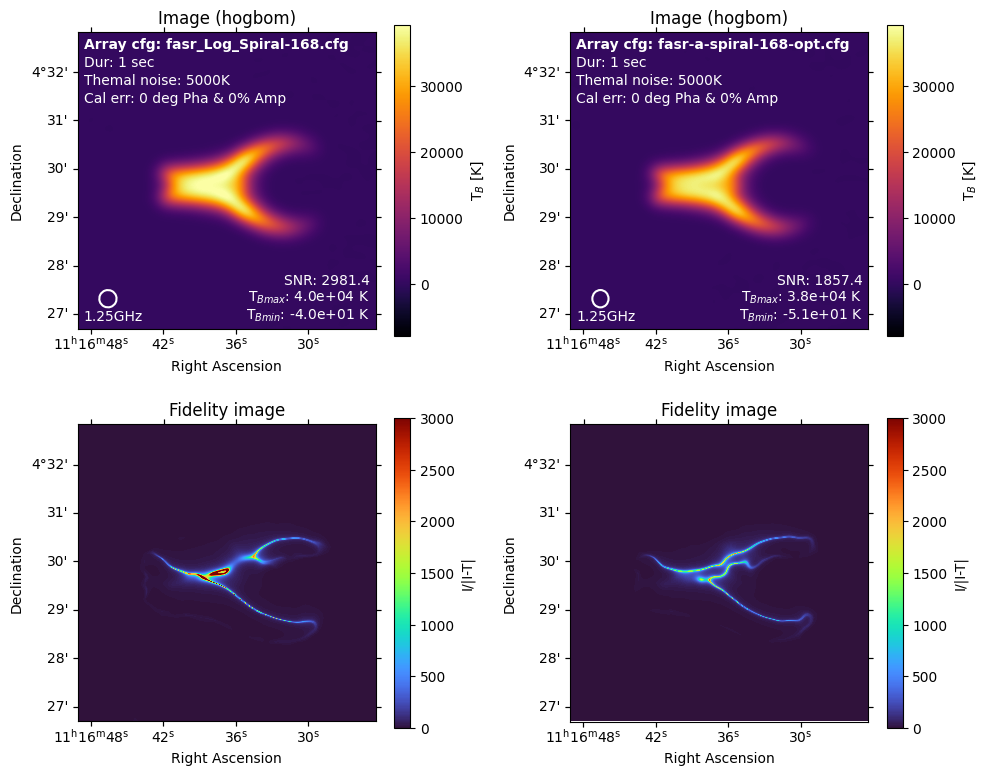

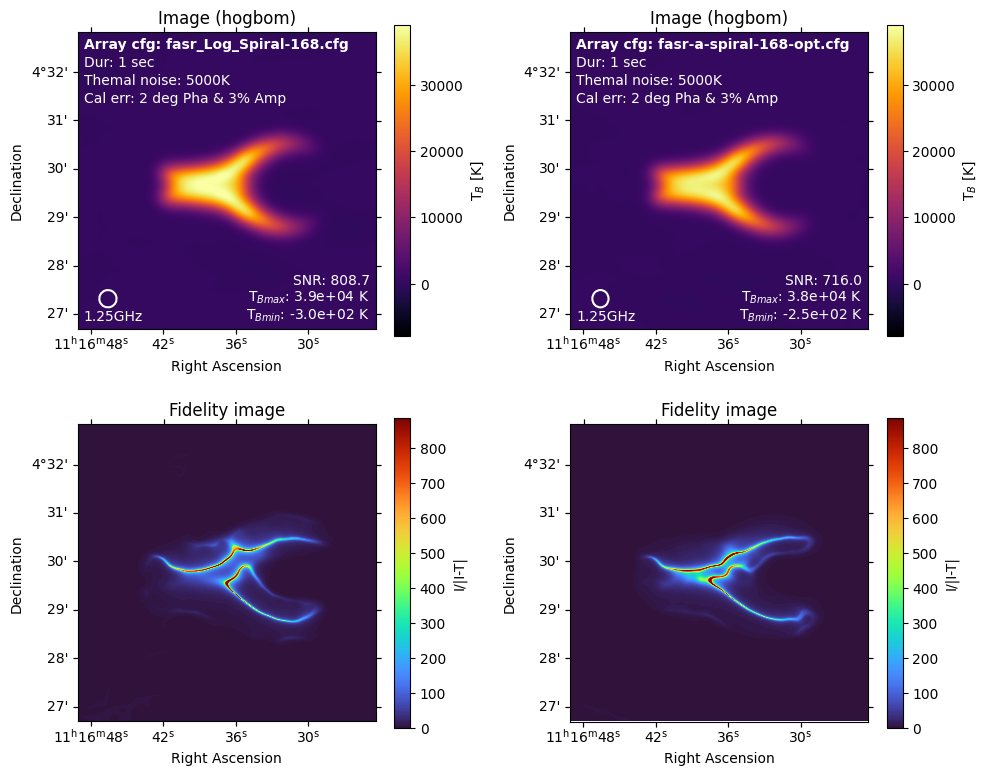

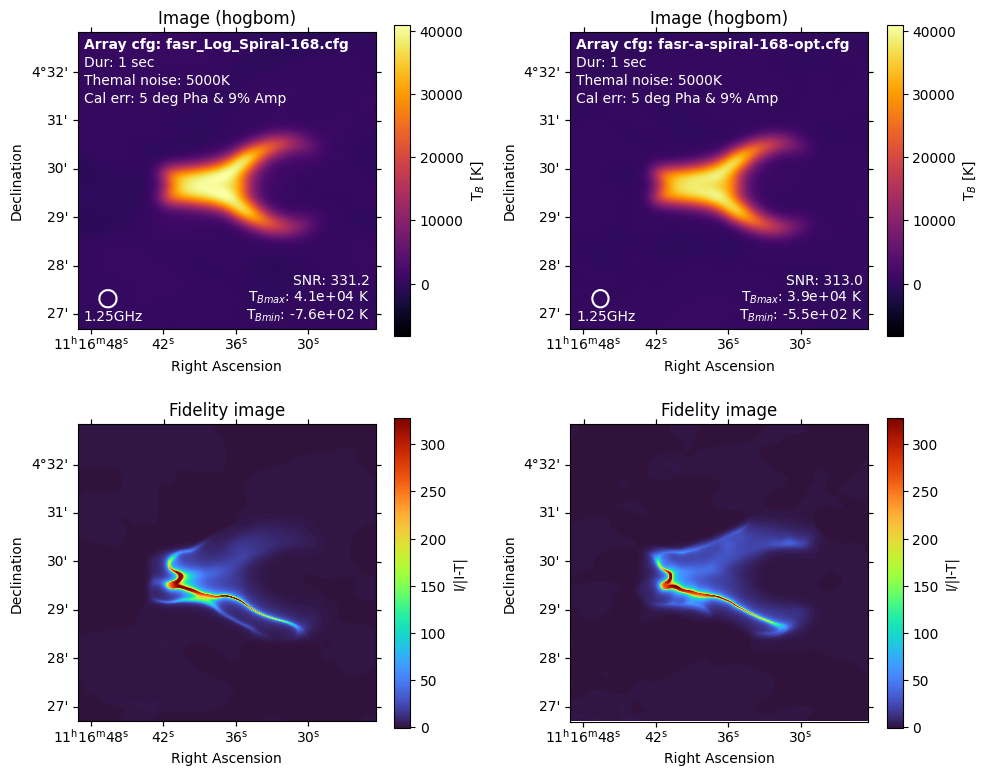

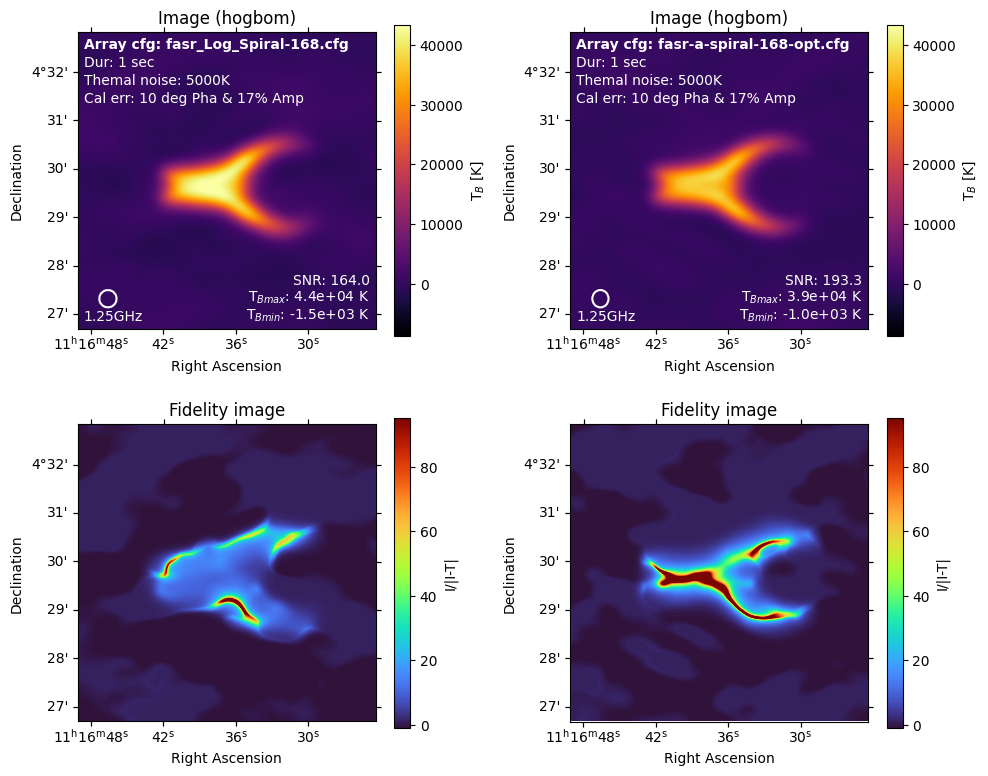

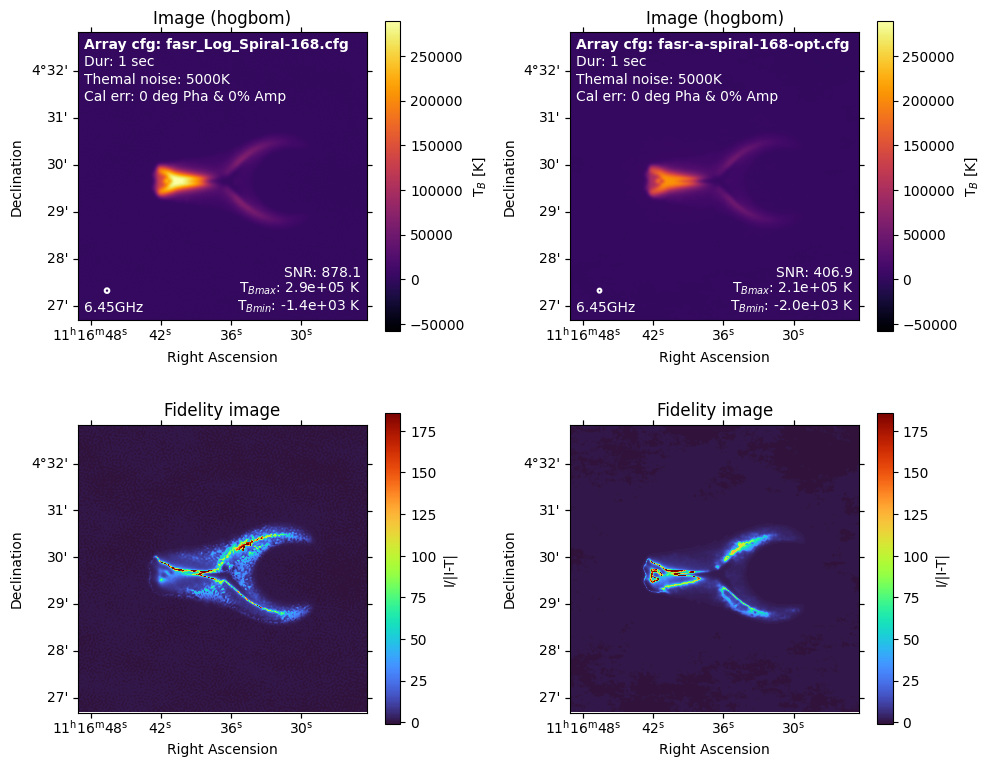

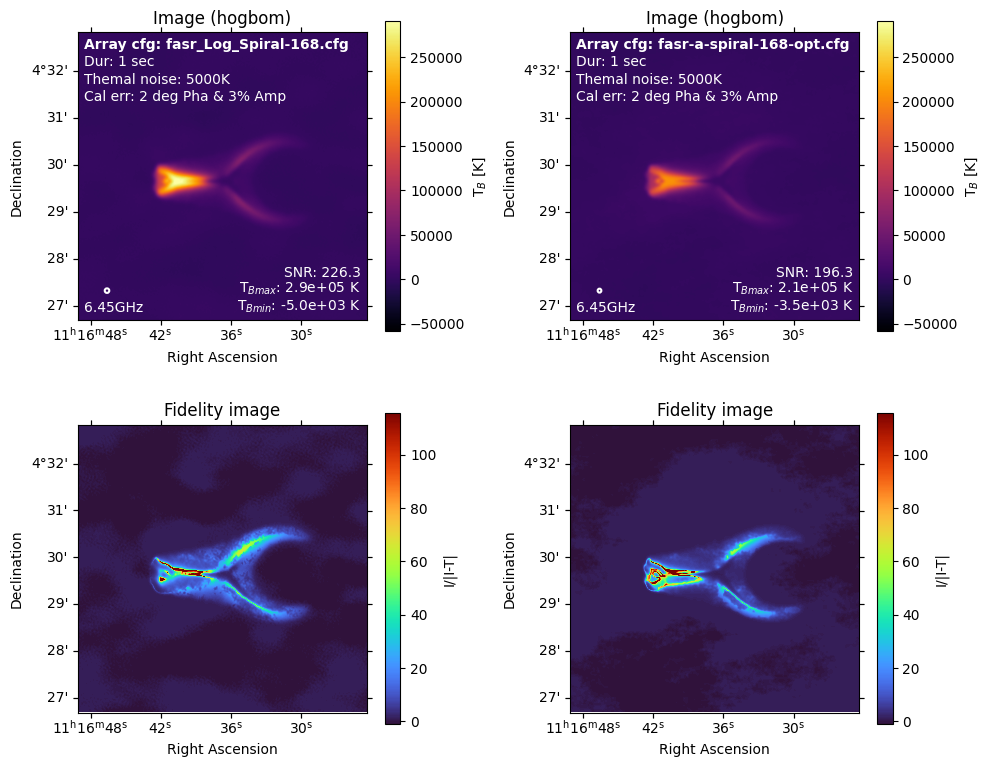

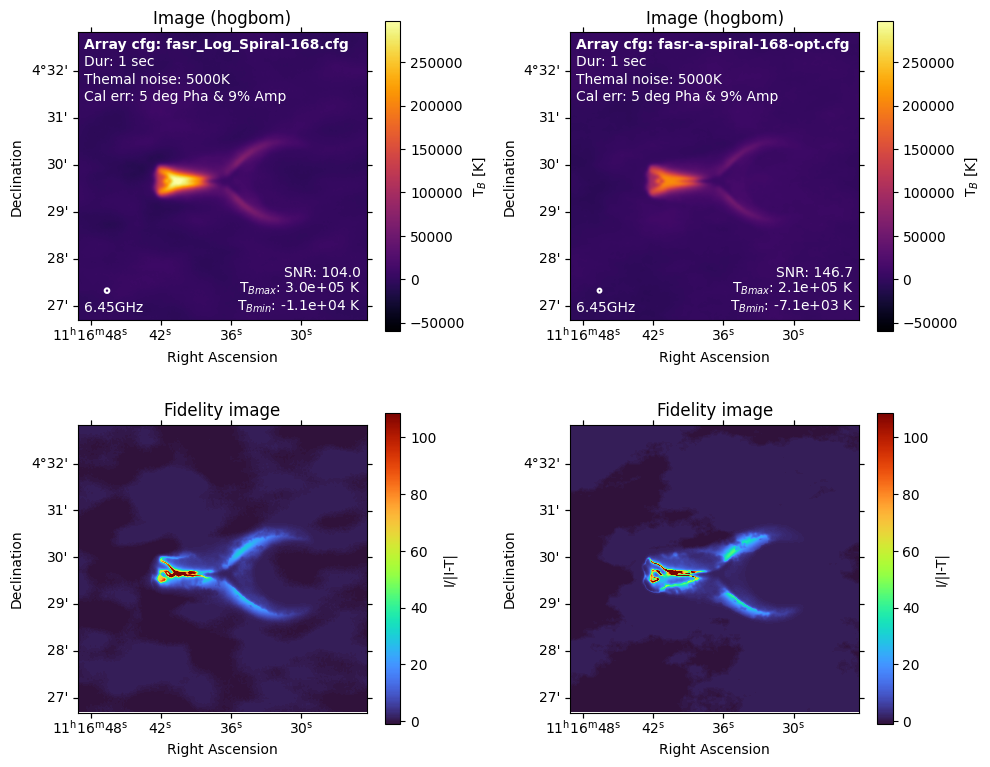

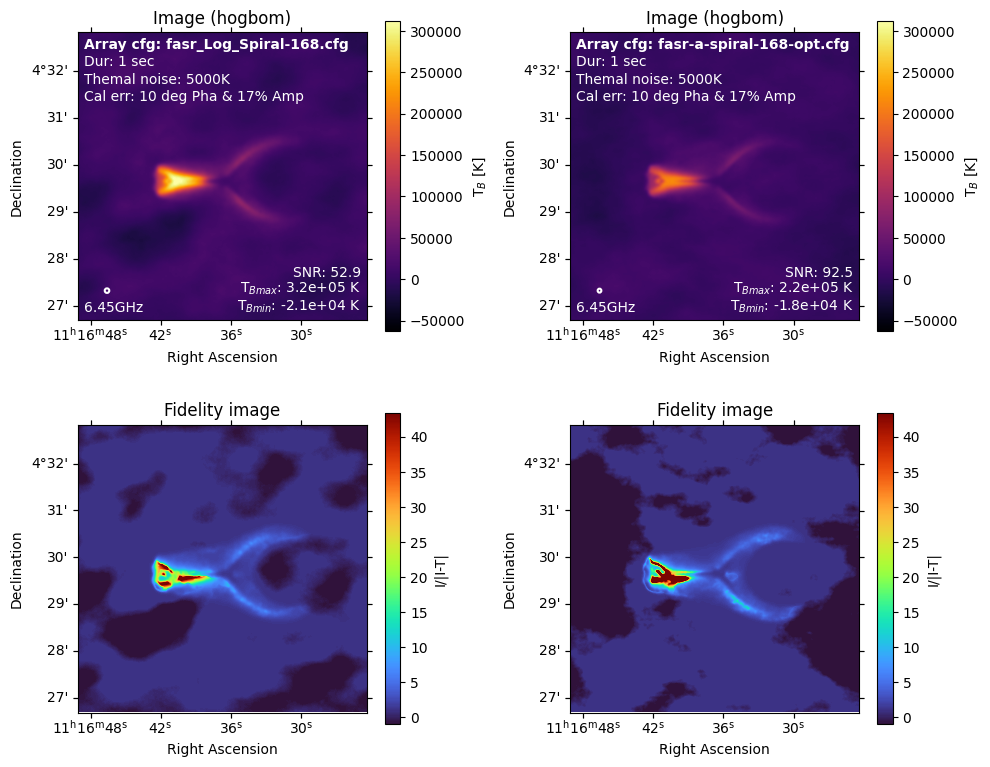

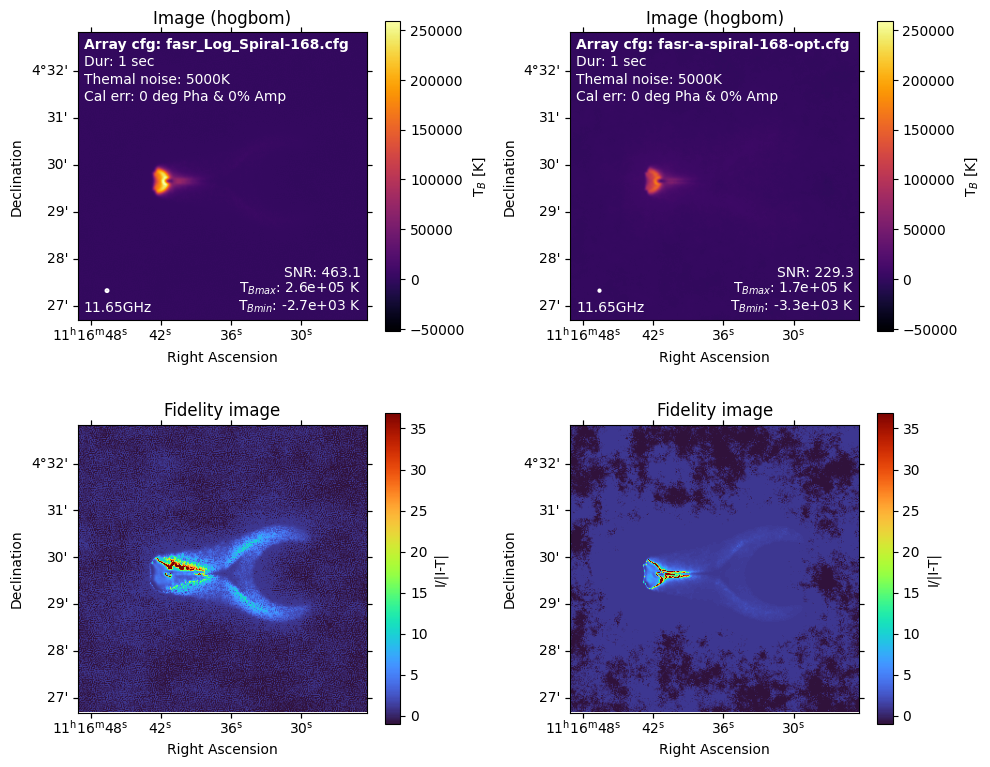

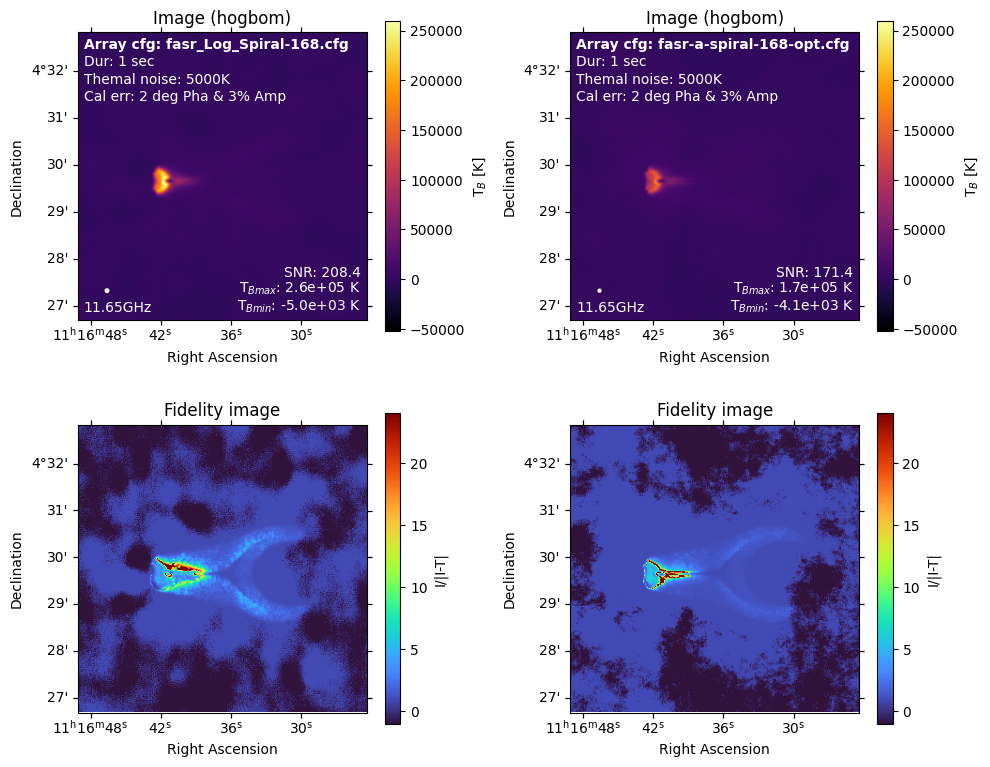

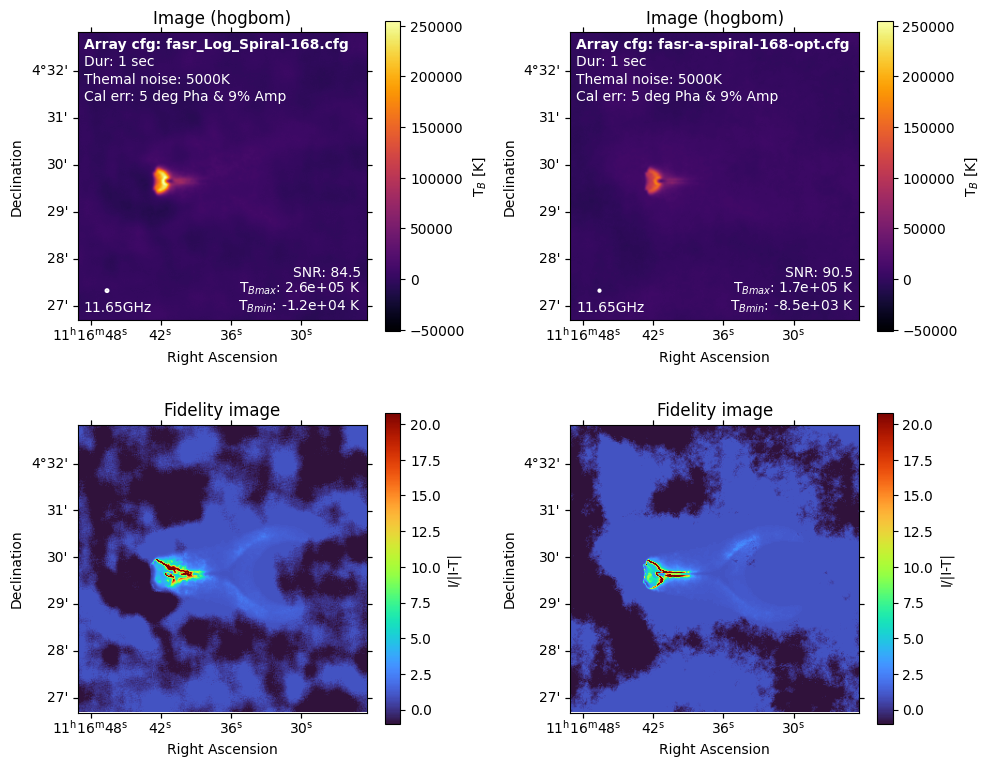

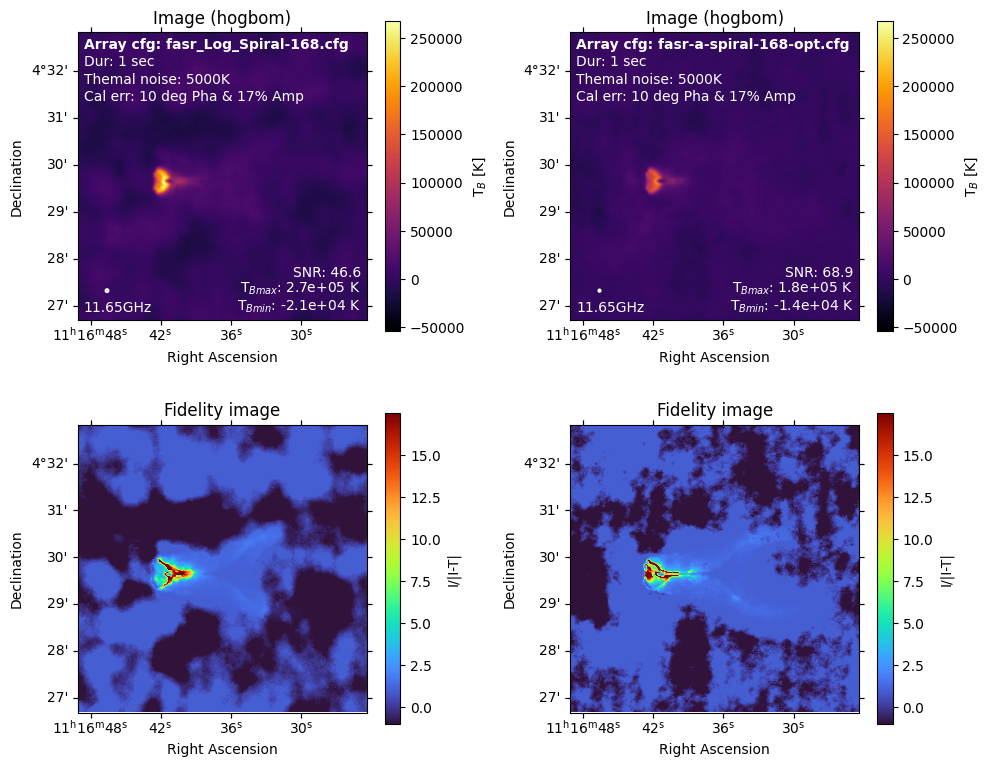

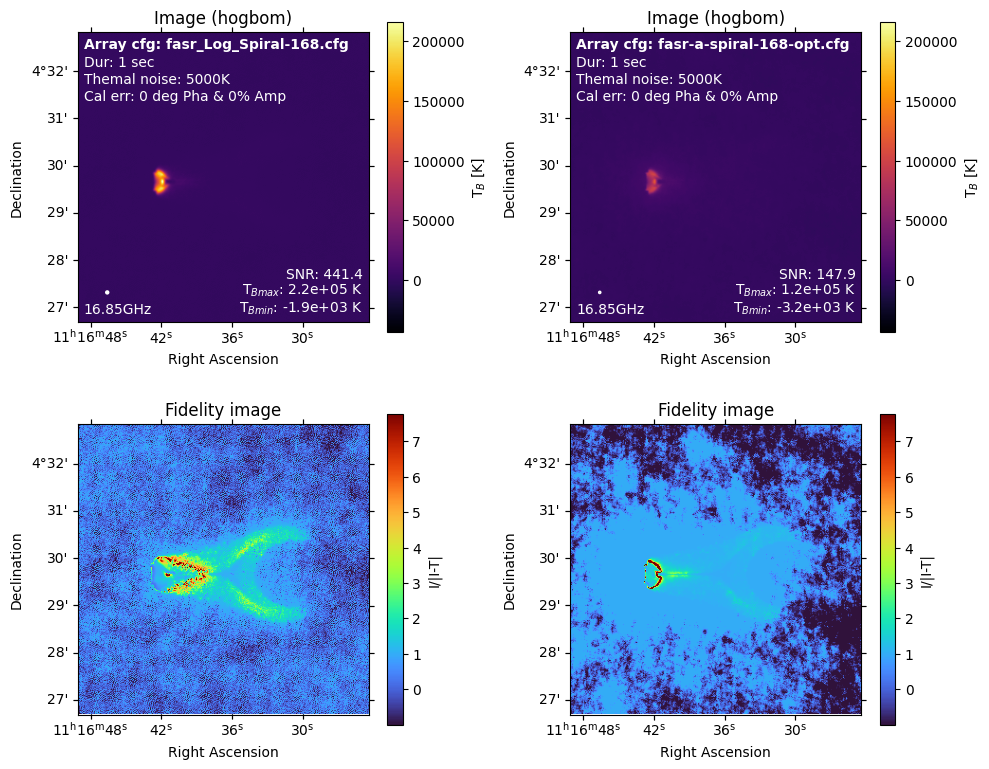

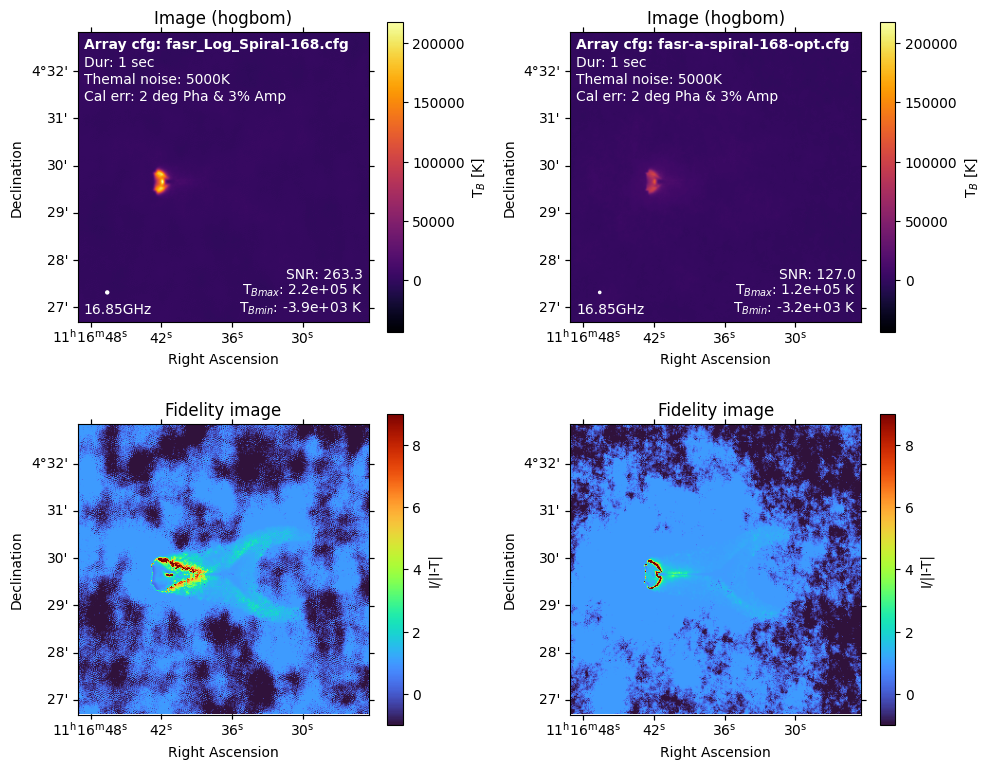

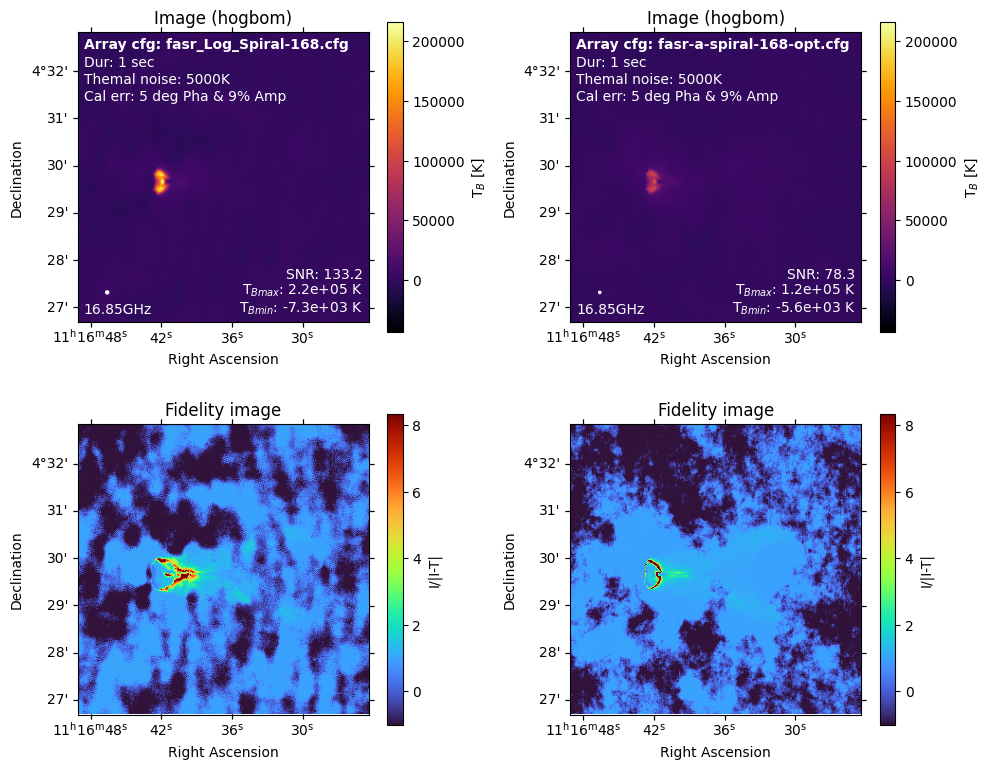

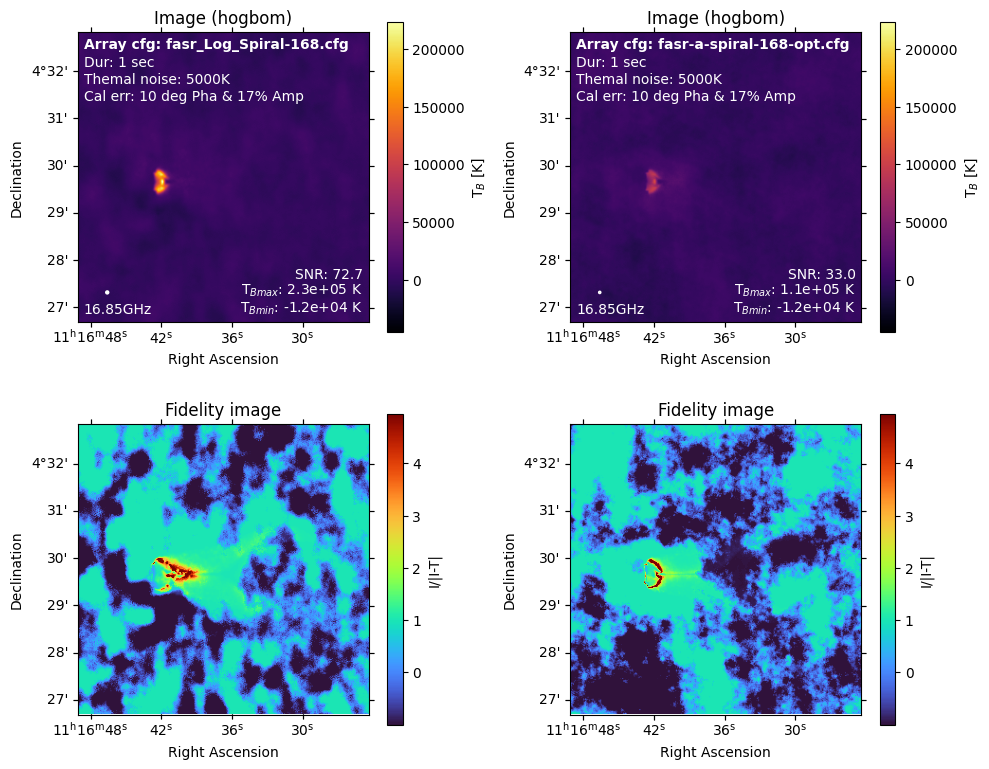

In [36]:
from importlib import reload
%matplotlib inline
reload(fss)
figdir = os.path.join(project, figsubfolder, target)
config_file1 = config_files[0]
cfg_suffix1 = os.path.basename(config_file1.rstrip(".cfg"))
config_file2 = config_files[1]
cfg_suffix2 = os.path.basename(config_file2.rstrip(".cfg"))

stats = {}
for freqstr in freq_list:
    solar_model = f'Eruptive_Flare/sep10_flare_cs_model.{freqstr}.I.fits'
    image1_model = os.path.join(project, 'msfiles', target,
                                os.path.basename(solar_model.replace('.fits', f'.{cfg_suffix1}.im.convolved')))
    image2_model = os.path.join(project, 'msfiles', target,
                                os.path.basename(solar_model.replace('.fits', f'.{cfg_suffix2}.im.convolved')))
    stats[freqstr] = {}
    for dur in duration:
        stats[freqstr][dur] = {}
        for noise in noise_levels:
            stats[freqstr][dur][noise] = {}
            msname1 = fss.make_msname(project, target, freqstr, reftime_obj, dur, integration_time, config_file1, noise)
            msname2 = fss.make_msname(project, target, freqstr, reftime_obj, dur, integration_time, config_file2, noise)
            for phaerr, amperr in cal_errors:
                figname = os.path.join(figdir,
                                       f'fig-{target}_{cfg_suffix1}-vs-{cfg_suffix2}_noise{noise}_dur{dur:.0f}s_phaerr{np.int_(phaerr * 100)}pct_amperr{np.int_(amperr * 100)}pct-{deconvolver}-{freqstr}-img-fidelity-blowup.jpg')
                if os.path.exists(figname):
                    if overwrite_plot:
                        os.system(f'rm -rf {figname}')

                if not os.path.exists(figname):
                    imname1 = fss.make_imname(msname1, deconvolver, phaerr, amperr)
                    image1 = imname1 + '.image'
                    title1 = f'{freqstr} {cfg_suffix1} {deconvolver}'

                    imname2 = fss.make_imname(msname2, deconvolver, phaerr, amperr)
                    image2 = imname2 + '.image'
                    title2 = f'{freqstr} {cfg_suffix2} {deconvolver}'
                    print(f'plotting image1: {image1} & image2 {image2}')
                    image_meta = {'title': [f'Image ({deconvolver})', f'Image ({deconvolver})'],
                                  'freq': freqstr.lstrip("0"),
                                  'array_config': config_files,
                                  'noise': f'{noise}',
                                  'cal_error': f'{np.int_(np.round(phaerr * 360))} deg Pha & {np.int_(np.round(amperr * 100))}% Amp',
                                  'duration': f'{dur:.0f} sec',
                                  }

                    fig, axs, meta = fss.plot_two_casa_images(image1, image2,
                                                        crop_fraction=((0.85, 1.0), (0.35 + 0.02, 0.50 + 0.02)),
                                                        figsize=(10, 4),
                                                        image_meta=image_meta,
                                                        cmap='inferno',
                                                        cmap_model='turbo',
                                                        vmax=99, vmin=-20,
                                                        vmax_percentile=99.9, vmin_percentile=1,
                                                        uni_vmaxmin=True,
                                                        image1_model_filename=image1_model,
                                                        image2_model_filename=image2_model,
                                                        contour_levels=[0.025, 0.05, 0.1, 0.2, 0.4, 0.8])
                    fig.savefig(figname, dpi=300)
                    stats[freqstr][dur][noise][f'{np.int_(np.round(phaerr * 360))} deg'] = meta


In [43]:
stats = metas

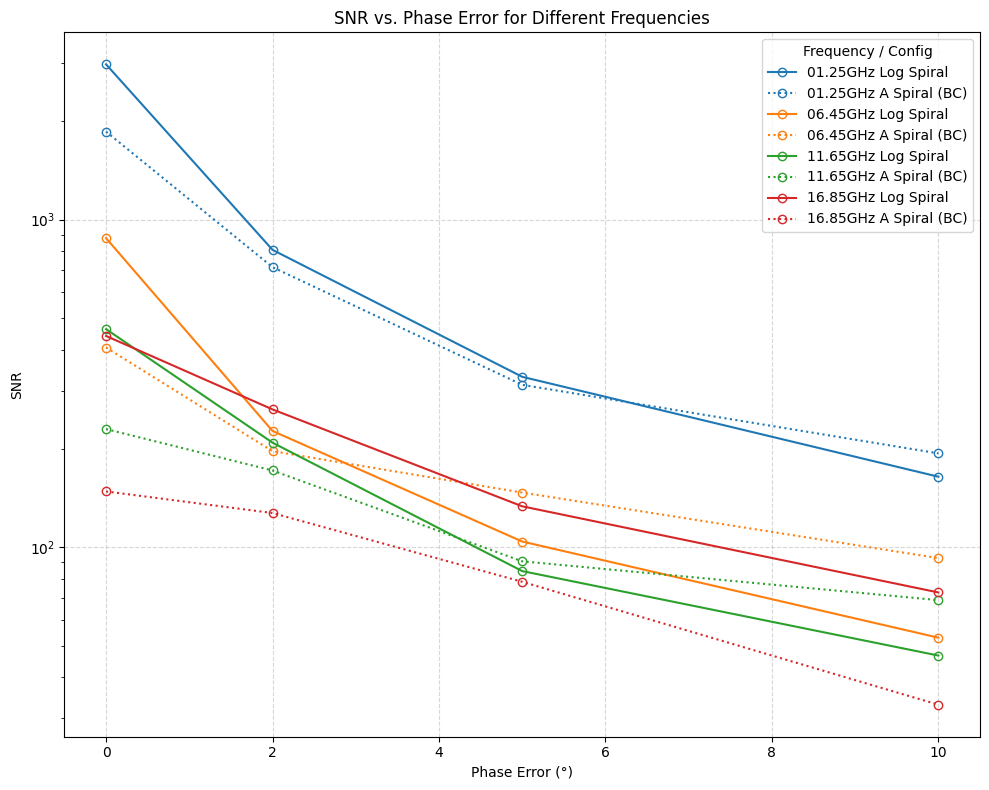

In [40]:
import numpy as np
import matplotlib.pyplot as plt

cfg_suffix1 = 'Log Spiral'
cfg_suffix2 = 'A Spiral (BC)'

# grab default color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax = plt.subplots(figsize=(10, 8))
for idx, (freq, freq_dict) in enumerate(stats.items()):
    phase_dict = freq_dict[1]['5000K']
    phases, snrs1, snrs2 = [], [], []

    for pha_str, stats in phase_dict.items():
        pha = float(pha_str.split()[0])
        s1, s2 = stats['snr']
        phases.append(pha)
        snrs1.append(s1)
        snrs2.append(s2)

    # sort by phase error
    phases, snrs1, snrs2 = zip(*sorted(zip(phases, snrs1, snrs2)))

    color = colors[idx % len(colors)]
    ax.plot(phases, snrs1, marker='o', linestyle='-', mec=color,mfc='none', color=color,
             label=f"{freq} {cfg_suffix1}")
    ax.plot(phases, snrs2, marker='o', linestyle=':', mec=color,mfc='none', color=color,
             label=f"{freq} {cfg_suffix2}")

ax.set_xlabel('Phase Error (°)')
ax.set_ylabel('SNR')
ax.set_title('SNR vs. Phase Error for Different Frequencies')
ax.legend(title='Frequency / Config')
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_yscale('log')
fig.tight_layout()

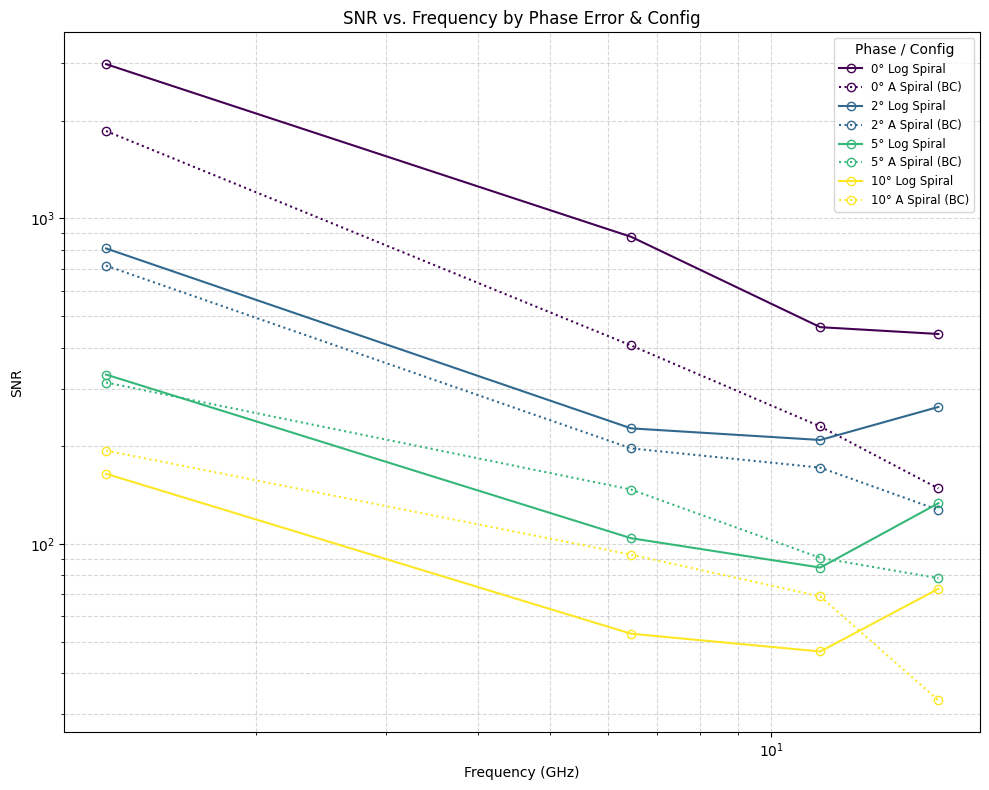

In [44]:
import numpy as np
import matplotlib.pyplot as plt

cfg1 = 'Log Spiral'
cfg2 = 'A Spiral (BC)'

# sort frequency keys numerically
freq_keys = sorted(stats.keys(), key=lambda s: float(s.rstrip('GHz')))
freqs = np.array([float(f.rstrip('GHz')) for f in freq_keys])

# collect and sort unique phase errors
phase_errors = sorted({
    float(k.split()[0])
    for f in freq_keys
    for k in stats[f][1]['5000K'].keys()
})

# generate one color per phase
colors = plt.cm.viridis(np.linspace(0, 1, len(phase_errors)))

fig, ax = plt.subplots(figsize=(10, 8))

for color, pha in zip(colors, phase_errors):
    snr1 = []
    snr2 = []
    for f in freq_keys:
        stat = stats[f][1]['5000K'][f"{int(pha)} deg"]['snr']
        snr1.append(stat[0])
        snr2.append(stat[1])
    ax.plot(freqs, snr1, 'o-', mec=color,mfc='none', color=color, label=f"{pha:.0f}° {cfg1}")
    ax.plot(freqs, snr2, 'o:', mec=color,mfc='none', color=color, label=f"{pha:.0f}° {cfg2}")

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('SNR')
ax.set_title('SNR vs. Frequency by Phase Error & Config')
ax.grid(True, which='both', ls='--', alpha=0.5)
ax.legend(title='Phase / Config', loc='best', fontsize='small')
plt.tight_layout()
plt.show()